In [1]:

# Import libraries 
import xml.etree.ElementTree as ET
import re
from typing import Counter
import functools
from functools import reduce
import itertools
from collections import ChainMap

In [8]:
# IMPORT posts.xml and make a tree object instance
from pathlib import Path
path_archivo= str(Path(globals()['_dh'][0]))[:-9]
tree = ET.parse(path_archivo+'datasets/posts.xml')
root = tree.getroot()


# Relación entre cantidad de palabras en un post y su cantidad de respuestas


In [9]:
# Entiendo que la cantidad de palabras en un post dividido la cantidad de veces que ParentID == PostId donde ,PostId es el post que le sumamos las palabras

# diccionario de cantidad de palabras por PostId 
# diccionario de cantidad de ParentId (seria ParentId:Contador(ParentId))

In [10]:
def chunckify(iterable,len_of_chunk):
    for i in range(0,len(iterable), len_of_chunk):
        yield iterable[i:i + len_of_chunk]
        

In [11]:
# Function to return a list of dict of parentid : count of times that it appears
def mapper1(data):
    parentId_mapeadas=list(map(get_ParentID,data))
    parentId_mapeadas= list(filter(None,parentId_mapeadas))
    list_dict_parentId= list(sum_Parent_ID(parentId_mapeadas))
    
    return list_dict_parentId


# Function to get a list of ParentID    
def get_ParentID(data):
    try:
        ParentId_id = data.attrib['ParentId']
        
    except:
            return    
    return ParentId_id


# Function to get the total of times that a ParentID its listed
def sum_Parent_ID(data):
    return Counter(data)





In [12]:
def mapper2(data):
# Get list of dicts with postid and the count of words in it   
    post_mapeadas=    list(map(get_Post,data))
    
    
    return post_mapeadas

def get_Post(data):
    # Get Body and postid list
    body = data.attrib['Body']
    postID = data.attrib['Id']
    # Clean the body and get a list of words
    body = re.findall('(?<!\S)[A-Za-z]+(?!\S)|(?<!\S)[A-Za-z]+(?=:(?!\S))',body)
    # Filter the None list objetcs
    body= list(filter(None,body))
    # count the number of words in each post
    counter_palabras = len(body)
    
    
    
    return {postID:counter_palabras}


In [13]:
# STEPS TO GET DICT WITH PARENT_ID vs COUNT OF TIMES THAT IS LISTED
#Get chunks of data to process
data_chunks = chunckify(root, 50)
mapped1 = list(map(mapper1,data_chunks))
#dict_posts_palabras = list(reduce(lambda a,b: a.update(b),mapped[:][1]))
# Make dict with the ParentID and the times that it appears
dict_ParentId=reduce(lambda x,y:Counter(x)+Counter(y),mapped1)




In [14]:

# STEPS TO GET DICT WITH POST_ID vs COUNT OF WORDS 
#Get chunks of data to process
data_chunks = chunckify(root, 50)
mapped2 = list(map(mapper2,data_chunks))
# TRANSFORM LIST OF DICT INTO A BIG DICT
mapped2=list(itertools.chain.from_iterable(mapped2))
postid_palabras = reduce(lambda d, src: d.update(src) or d, mapped2,{})



In [15]:
#postid_palabras < diccionario de posts y palabras
print(len(postid_palabras))
#dict_ParentId < diccionario de parent id
print(len(dict_ParentId))

56974
13805


# As its shown we have near to 4 times more questions than answers

In [11]:

# Get list of keys 
post_con_respuesta=list(dict_ParentId.keys())

# Function to generate dict of postID and amount of word 
def genera_palabras_dict(data,postid_palabras=postid_palabras):
    return {data:postid_palabras[data]}

# Generate list of dicts with postID and amount of word    
postid_palabras_limpio=list(map(genera_palabras_dict,post_con_respuesta))
# Convert list of dicts in one big dicts
postid_palabras_limpio = reduce(lambda d, src: d.update(src) or d, postid_palabras_limpio,{})


In [12]:
#postid_palabras < diccionario de posts y palabras
print(len(postid_palabras_limpio))
#dict_ParentId < diccionario de parent id
print(len(dict_ParentId))

13805
13805


In [13]:
def relacion(data,postid_palabras_limpio=postid_palabras_limpio,dict_ParentId=dict_ParentId):
# Function to get relationship between amount of answers / amount of words in post 
    try:
        # This try clause is because there are many post with 0 words
        relacion_porc = (dict_ParentId[data]/postid_palabras_limpio[data])*100
        return (data,relacion_porc)
        # Case post words count is 0 will ignore it
    except ZeroDivisionError:
        return 
    
# Get a list of tuples with post ID and relationship    
lista_relacion=list(map(relacion,post_con_respuesta))

In [14]:
# LIST OF TUPLES  ( POST ID ,  % BETWEEN AMOUNT OF ANSWERS / AMOUNT OF WORDS IN POST  ) 
lista_relacion[:10]

[('1', 11.29032258064516),
 ('13', 10.0),
 ('6', 6.122448979591836),
 ('11', 1.3605442176870748),
 ('16', 2.2222222222222223),
 ('10', 16.666666666666664),
 ('20', 50.0),
 ('9', 2.0689655172413794),
 ('25', 61.111111111111114),
 ('31', 22.727272727272727)]

In [15]:
# Create a dataframe object with the data that was output of the ETL process

import pandas as pd

pd_relacion = pd.DataFrame(lista_relacion)
pd_relacion = pd_relacion.set_index(0)

In [16]:
# Dataframe obtained
pd_relacion

,1
0,
1,11.290323
13,10.000000
6,6.122449
11,1.360544
16,2.222222
...,...
69056,1.754386
69060,0.460829
69063,0.719424


In [17]:
pd_relacion.describe()

,1
count,13786.000000
mean,4.059200
std,9.457816
min,0.082781
25%,1.298701
50%,2.316637
75%,4.285714
max,750.000000


The values that we can see starts in 0 because its a relationship obtained by a division (val1/val2)
A min value close to 0 tell us that there are posts with any of this conditions
1) Many words (and or code on the post)
2) Few words with a lot of answers

In the other hand we see that the mean is 4.06 , that mean that for each answer there was 4 words on the question, There is not too much information in every question if we think about it, or there are a lot of answers for every question.
To answer that point we look back for the amount of words in the posts

In [18]:
#postid_palabras_limpio
pd_cantidad_palabras = pd.DataFrame(postid_palabras_limpio,index=[0])
pd_cantidad_palabras=pd_cantidad_palabras.T

In [19]:
pd_cantidad_palabras.describe()

,0
count,13805.000000
mean,78.478667
std,78.919490
min,0.000000
25%,32.000000
50%,56.000000
75%,97.000000
max,1436.000000


Looking for the posts that were answered we see that the mean of words are 78, in that case we can suggest that the mean of the answered questions has 78.47/4.06 answers
Also we can see that the STD of the amount of words in answered posts its the same that the mean, instead of it the STD of the relationship between the answers/words its the twice that its mean, so we can suggest that there shouldnt be a linear relationship between the words and the time that a post was answered.


In [32]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

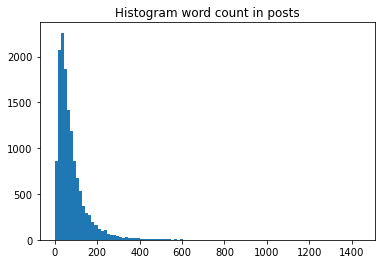

In [42]:
plt.hist(pd_cantidad_palabras,bins=100)
plt.title("Histogram word count in posts")
plt.show()

The graph and the describe function show that the mos part of the posts has less than 150 words and are arround 75

In [24]:
# To extend this we are going to check if there is any relation between the words in a post and the answers that it has

def relacion_2(data,postid_palabras_limpio=postid_palabras_limpio,dict_ParentId=dict_ParentId):
    return (dict_ParentId[data],postid_palabras_limpio[data])
        
# Get a list of tuples with post ID and relationship    
lista_tuplas_analizar=list(map(relacion_2,post_con_respuesta))

In [27]:
lista_listas_analizar=list(map(list,zip(*lista_tuplas_analizar)))

In [49]:
print(len(lista_listas_analizar[0]))
print(len(lista_listas_analizar[1]))

pd_lista_listas_analizar_0=pd.DataFrame(lista_listas_analizar[0])
pd_lista_listas_analizar_1=pd.DataFrame(lista_listas_analizar[1])

13805
13805


In [56]:
pd_lista_listas_analizar_0.describe()

,0
count,13805.000000
mean,1.565809
std,1.624203
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,75.000000


The mean count of answers for each question is 1.5  and the value of the STD its almost the same value that the mean.
We can suggest that every question could have between no answers and 3 answers 


In [61]:
pd_lista_listas_analizar_0.corrwith(pd_lista_listas_analizar_1,axis=0)

0    0.096793
dtype: float64

The correlation between the two dataframes is really low

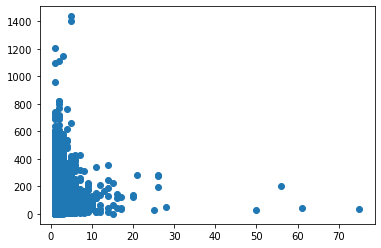

In [67]:
plt.scatter(pd_lista_listas_analizar_0,pd_lista_listas_analizar_1)

In [ ]:
The last graph shows that we have some outliers that can be removed to get a better analysis

In [88]:
pd_ans_word=pd.DataFrame()
pd_ans_word['Answers']=pd_lista_listas_analizar_0
pd_ans_word['Words_count']=pd_lista_listas_analizar_1


pd_ans_word.describe()

,Answers,Words_count
count,13805.000000,13805.000000
mean,1.565809,78.478667
std,1.624203,78.919490
min,1.000000,0.000000
25%,1.000000,32.000000
50%,1.000000,56.000000
75%,2.000000,97.000000
max,75.000000,1436.000000


In [99]:
# This code its to remove outliers, usually the value that we take its zscore < 3 

import numpy as np
from scipy import stats
z_scores = stats.zscore(pd_ans_word)
abs_z_scores= np.abs(z_scores)
filtered_entries= (abs_z_scores < 3).all(axis=1)
pd_ans_word_n_o = pd_ans_word[filtered_entries]


In [100]:
pd_ans_word_n_o.describe()

,Answers,Words_count
count,13422.000000,13422.000000
mean,1.457458,71.185367
std,0.834275,55.883733
min,1.000000,0.000000
25%,1.000000,31.000000
50%,1.000000,55.000000
75%,2.000000,94.000000
max,6.000000,315.000000


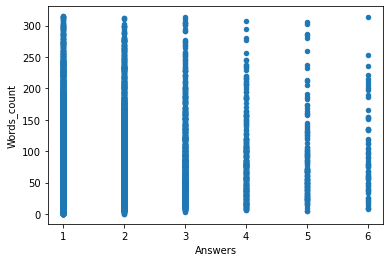

In [101]:
pd_ans_word_n_o.plot(x='Answers',y='Words_count',kind='scatter')
plt.show()

In this graph we can see that if we remove the outliers (383 registries - 2.77% of the total values) the 97.23% of the questions that has at least 1 answer recive between 1 and 6 answers




